In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/soil-measures/soil_measures.csv")
df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [3]:
#The output informs that there aren't any missing values in our dataset
df.isna().sum().sort_values()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [4]:
#There is minute differences in the measure of cetranl tendencies, 
#but it is always better to center the data and there aren't any categorical data or string data so we don't need to encode anything
print(df.describe())
print(df['crop'].unique())
print(df['crop'].nunique())

                 N            P            K           ph
count  2200.000000  2200.000000  2200.000000  2200.000000
mean     50.551818    53.362727    48.149091     6.469480
std      36.917334    32.985883    50.647931     0.773938
min       0.000000     5.000000     5.000000     3.504752
25%      21.000000    28.000000    20.000000     5.971693
50%      37.000000    51.000000    32.000000     6.425045
75%      84.250000    68.000000    49.000000     6.923643
max     140.000000   145.000000   205.000000     9.935091
['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
22


In [5]:
#Diving the dataset before centering so that it does not have data leakage(This can lead to information about the test set leaking into the training set)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = df.drop("crop", axis=1).values 
y = df["crop"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  
random_state=116)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
#From the output we can understand there isn't any class imbalance too
unique_classes, class_counts = np.unique(y, return_counts=True)
class_counts_dict = dict(zip(unique_classes, class_counts))

print(class_counts_dict)

{'apple': 100, 'banana': 100, 'blackgram': 100, 'chickpea': 100, 'coconut': 100, 'coffee': 100, 'cotton': 100, 'grapes': 100, 'jute': 100, 'kidneybeans': 100, 'lentil': 100, 'maize': 100, 'mango': 100, 'mothbeans': 100, 'mungbean': 100, 'muskmelon': 100, 'orange': 100, 'papaya': 100, 'pigeonpeas': 100, 'pomegranate': 100, 'rice': 100, 'watermelon': 100}


In [7]:
# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_test_scaled_df = pd.DataFrame(X_test_scaled)

train_df = pd.concat([X_train_scaled_df, pd.Series(y_train)], axis=1)
test_df = pd.concat([X_test_scaled_df, pd.Series(y_test)], axis=1)
df1 = pd.concat([train_df, test_df], ignore_index=True)
df1.describe()

,0,1,2,3
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,-0.277831,-0.309104,-0.568509,-0.077894
std,0.527390,0.471227,0.506479,0.240714
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.700000,-0.671429,-0.850000,-0.232718
50%,-0.471429,-0.342857,-0.730000,-0.091714
75%,0.203571,-0.100000,-0.560000,0.063362
max,1.000000,1.000000,1.000000,1.000000


In [8]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((1650, 4), (1650,), (550, 4), (550,))

In [9]:
train_accuracies = []
test_accuracies = []
f1_scores = []
recall_scores = []
precision_scores = []

### KNN

In [10]:
"""from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
knn = KNeighborsClassifier(22)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))"""

'from sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.metrics import classification_report\nknn = KNeighborsClassifier(22)\nknn.fit(X_train_scaled,y_train)\ny_pred = knn.predict(X_test_scaled)\nprint(classification_report(y_test, y_pred))'

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

n_neighbors_range = np.arange(2, 23)

param_grid_knn = {
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_knn_model = None
best_knn_score = float('-inf')

for n_neighbors in n_neighbors_range:
    print(f"Performing cross-validation for n_neighbors = {n_neighbors}:")
    
    param_grid_knn['n_neighbors'] = [n_neighbors]
    
    for num_folds in num_folds_list:
        print(f"Number of folds: {num_folds}")
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

        knn = KNeighborsClassifier()

        knn_cv = RandomizedSearchCV(knn, param_grid_knn, cv=kf, n_iter=10, random_state=116)
        knn_cv.fit(X_train_scaled, y_train)
        knn_acc = knn_cv.score(X_train_scaled, y_train)

        print("Best parameters:", knn_cv.best_params_)
        print("Best score:", knn_cv.best_score_)
        print("acc:",knn_acc)
        
        if knn_cv.best_score_ > best_knn_score:
            best_knn_model = knn_cv.best_estimator_
            best_knn_score = knn_cv.best_score_

        print()


Performing cross-validation for n_neighbors = 2:
Number of folds: 5
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7260606060606061
acc: 0.8624242424242424

Number of folds: 10
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7351515151515151
acc: 0.8624242424242424

Number of folds: 15
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7321212121212122
acc: 0.8624242424242424

Number of folds: 20
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7314942697619748
acc: 0.8624242424242424

Number of folds: 22
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7339393939393939
acc: 0.8624242424242424

Number of folds: 25
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7363636363636362
acc: 0.8624242424242424

Performing cross-validation for n_neighbors = 3:
Number of folds: 5
Best parameters: {'p': 1, 

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

train_score_knn = best_knn_model.score(X_train_scaled,y_train)
test_score_knn = best_knn_score

y_pred = best_knn_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_knn)
test_accuracies.append(test_score_knn)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_knn_model)
print(train_score_knn)
print(test_score_knn)
print(f1)
print(recall)
print(precision)

KNeighborsClassifier(metric='manhattan', n_neighbors=11, p=1)
0.8109090909090909
0.7606060606060606
74.28
75.66
75.72


In [13]:
"""import os
import shutil

files_in_working_dir = os.listdir('/kaggle/working/')
for item in files_in_working_dir:
    if os.path.isfile(item):
        os.remove(item)
    else:
        shutil.rmtree(item)
print("Contents of /kaggle/working/ have been cleared.")"""

'import os\nimport shutil\n\nfiles_in_working_dir = os.listdir(\'/kaggle/working/\')\nfor item in files_in_working_dir:\n    if os.path.isfile(item):\n        os.remove(item)\n    else:\n        shutil.rmtree(item)\nprint("Contents of /kaggle/working/ have been cleared.")'

In [14]:
import joblib


joblib.dump(best_knn_model, 'best_knn_model.pkl')
knn_model = joblib.load('best_knn_model.pkl')

#kf = KFold(n_splits=15, shuffle=True, random_state=116) 
#knn = knn_model

#scores = cross_val_score(knn, X_train_scaled, y_train, cv=kf)
#print(np.mean(scores))

### Logreg Multinomial

In [17]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_logreg_model = None
best_logreg_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    logreg = LogisticRegression(multi_class='multinomial',random_state=116)

    logreg_cv = RandomizedSearchCV(logreg, param_grid_logreg, cv=kf, n_iter=30, random_state=116)
    logreg_cv.fit(X_train_scaled, y_train)
    logreg_acc = logreg_cv.score(X_train_scaled, y_train)

    print("Best parameters:", logreg_cv.best_params_)
    print("Best score:", logreg_cv.best_score_)
    print("acc:",logreg_acc)
        
    if logreg_cv.best_score_ > best_logreg_score:
        best_logreg_model = logreg_cv.best_estimator_
        best_logreg_score = logreg_cv.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 1000.0}
Best score: 0.7157575757575758
acc: 0.7375757575757576

Performing cross-validation with 10 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 1000.0}
Best score: 0.7127272727272728
acc: 0.7375757575757576

Performing cross-validation with 15 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.7151515151515152
acc: 0.7393939393939394

Performing cross-validation with 20 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.7109462239200706
acc: 0.7393939393939394

Performing cross-validation with 22 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.7169696969696969
acc: 0.7393939393939394

Performing cross-validation with 25 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', '

In [18]:
train_score_logreg = best_logreg_model.score(X_train_scaled,y_train)
test_score_logreg = best_logreg_score

y_pred = best_logreg_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_logreg)
test_accuracies.append(test_score_logreg)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_logreg_model)
print(train_score_logreg)
print(test_score_logreg)
print(f1)
print(recall)
print(precision)

LogisticRegression(C=10.0, max_iter=400, multi_class='multinomial',
                   penalty='l1', random_state=116, solver='saga')
0.7393939393939394
0.7169696969696969
66.44
67.35
66.84


### DT

In [19]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_dt_model = None
best_dt_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    dt_classifier = DecisionTreeClassifier(random_state=116)

    dt_cv = RandomizedSearchCV(dt_classifier, param_grid_decision_tree, cv=kf, n_iter=168, random_state=116)
    dt_cv.fit(X_train_scaled, y_train)
    dt_acc = dt_cv.score(X_train_scaled, y_train)

    print("Best parameters:", dt_cv.best_params_)
    print("Best score:", dt_cv.best_score_)
    print("acc:",dt_acc)
        
    if dt_cv.best_score_ > best_dt_score:
        best_dt_model = dt_cv.best_estimator_
        best_dt_score = dt_cv.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7896969696969697
acc: 0.8781818181818182

Performing cross-validation with 10 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7981818181818182
acc: 0.8781818181818182

Performing cross-validation with 15 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7933333333333334
acc: 0.8848484848484849

Performing cross-validation with 20 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7926535409932413
acc: 0.8781818181818182

Performing cross-validati

In [20]:
train_score_dt = best_dt_model.score(X_train_scaled,y_train)
test_score_dt = best_dt_score

y_pred = best_dt_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_dt)
test_accuracies.append(test_score_dt)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_dt_model)
print(train_score_dt)
print(test_score_dt)
print(f1)
print(recall)
print(precision)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=116)
0.8781818181818182
0.7981818181818182
79.83
81.35
82.25


### RF

In [21]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_grid_random_forest = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_rf_model = None
best_rf_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    rf_classifier = RandomForestClassifier(random_state=116)

    rf_cv = RandomizedSearchCV(rf_classifier, param_grid_random_forest, cv=kf, n_iter=10, random_state=116)
    rf_cv.fit(X_train_scaled, y_train)
    rf_acc = rf_cv.score(X_train_scaled, y_train)

    print("Best parameters:", rf_cv.best_params_)
    print("Best score:", rf_cv.best_score_)
    print("acc:",rf_acc)

    if rf_cv.best_score_ > best_rf_score:
        best_rf_model = rf_cv.best_estimator_
        best_rf_score = rf_cv.best_score_
    
    print()

Performing cross-validation with 5 folds:
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Best score: 0.8042424242424243
acc: 0.8987878787878788

Performing cross-validation with 10 folds:
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
Best score: 0.8042424242424243
acc: 0.9503030303030303

Performing cross-validation with 15 folds:
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Best score: 0.806060606060606
acc: 0.8987878787878788

Performing cross-validation with 20 folds:
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'bo

In [22]:
train_score_rf = best_rf_model.score(X_train_scaled,y_train)
test_score_rf = best_rf_score

y_pred = best_rf_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_rf)
test_accuracies.append(test_score_rf)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_rf_model)
print(train_score_rf)
print(test_score_rf)
print(f1)
print(recall)
print(precision)

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=10,
                       random_state=116)
0.9503030303030303
0.8078533646782251
77.57
78.09
77.93


### SVC

In [23]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.svm import SVC
import numpy as np

param_grid_svc = {
    'C': np.logspace(-3, 3, 10),              
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4],                      
    'gamma': ['scale', 'auto'],               
    'coef0': [0.0, 1.0, 2.0],                 
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_svc_model = None
best_svc_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    svc_classifier = SVC(random_state=116)

    svc_cv = RandomizedSearchCV(svc_classifier, param_grid_svc, cv=kf, n_iter=168, random_state=116)
    svc_cv.fit(X_train_scaled, y_train)
    svc_acc = svc_cv.score(X_train_scaled, y_train)

    print("Best parameters:", svc_cv.best_params_)
    print("Best score:", svc_cv.best_score_)
    print("acc:",svc_acc)
        
    if svc_cv.best_score_ > best_svc_score:
        best_svc_model = svc_cv.best_estimator_
        best_svc_score = svc_cv.best_score_
        
    print()

Performing cross-validation with 5 folds:
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'coef0': 1.0, 'C': 215.44346900318823}
Best score: 0.7806060606060606
acc: 0.8363636363636363

Performing cross-validation with 10 folds:
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'coef0': 1.0, 'C': 215.44346900318823}
Best score: 0.7854545454545454
acc: 0.8363636363636363

Performing cross-validation with 15 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 1000.0}
Best score: 0.7854545454545454
acc: 0.8466666666666667

Performing cross-validation with 20 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 1000.0}
Best score: 0.7824493094328534
acc: 0.8466666666666667

Performing cross-validation with 22 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 1000.0}
Best score: 0.7824242424242424
acc: 0.8466666666666667

Performing cro

In [24]:
train_score_svc = best_svc_model.score(X_train_scaled,y_train)
test_score_svc = best_svc_score

y_pred = best_svc_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_svc)
test_accuracies.append(test_score_svc)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_svc_model)
print(train_score_svc)
print(test_score_svc)
print(f1)
print(recall)
print(precision)

SVC(C=1000.0, kernel='poly', random_state=116)
0.8466666666666667
0.7884848484848485
77.11
78.34
78.37


### GNB

In [25]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB


gnb_classifier = GaussianNB(priors = None,var_smoothing = 1e-9)
gnb_classifier.fit(X_train_scaled,y_train)
    
print(gnb_classifier.score(X_train_scaled,y_train))
print(gnb_classifier.score(X_test_scaled,y_test))

0.8024242424242424
0.76


In [26]:
train_score_gnb = gnb_classifier.score(X_train_scaled,y_train)
test_score_gnb = gnb_classifier.score(X_test_scaled,y_test)

y_pred = gnb_classifier.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)


train_accuracies.append(train_score_gnb)
test_accuracies.append(test_score_gnb)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(train_score_gnb)
print(test_score_gnb)
print(f1)
print(recall)
print(precision)

0.8024242424242424
0.76
76.19
77.14
76.71


### Predicting the crop type

In [46]:
test1 = np.array([39,139,201,5.5])
test1 = test1.reshape(-1,1)
test1 = np.reshape(test1, (1, 4))
pred1 = best_dt_model.predict(test1)
pred1

array(['grapes'], dtype=object)

### Plotting the results

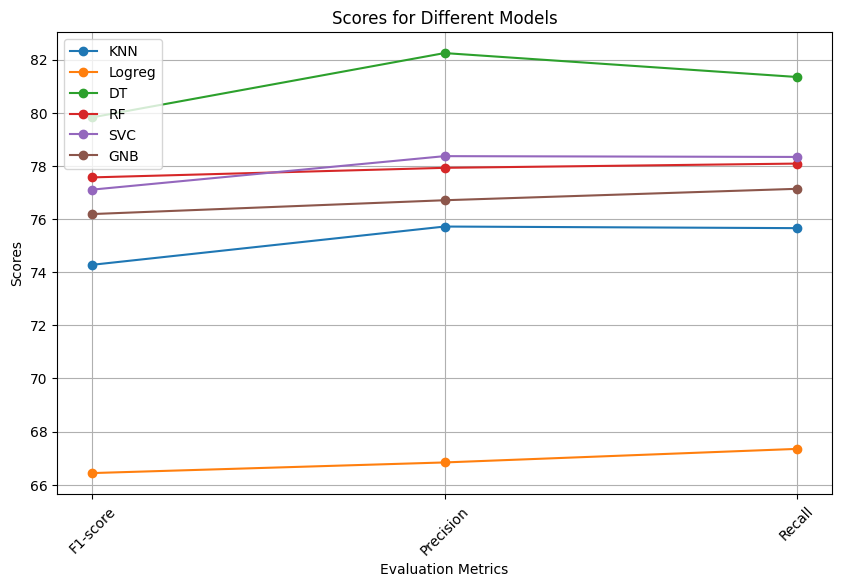

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

model_names = ['KNN', 'Logreg', 'DT', 'RF', 'SVC', 'GNB']

model_scores = [f1_scores, precision_scores, recall_scores]
score_labels = ['F1-score','Precision' ,'Recall']
plt.plot(score_labels, model_scores, marker='o', label=model_names)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('Scores for Different Models')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [28]:
print(train_accuracies,test_accuracies,f1_scores,recall_scores,precision_scores)
print(len(train_accuracies),len(test_accuracies),len(f1_scores),len(recall_scores),len(precision_scores))

[0.8109090909090909, 0.7393939393939394, 0.8781818181818182, 0.9503030303030303, 0.8466666666666667, 0.8024242424242424] [0.7606060606060606, 0.7169696969696969, 0.7981818181818182, 0.8078533646782251, 0.7884848484848485, 0.76] [74.28, 66.44, 79.83, 77.57, 77.11, 76.19] [75.66, 67.35, 81.35, 78.09, 78.34, 77.14] [75.72, 66.84, 82.25, 77.93, 78.37, 76.71]
6 6 6 6 6


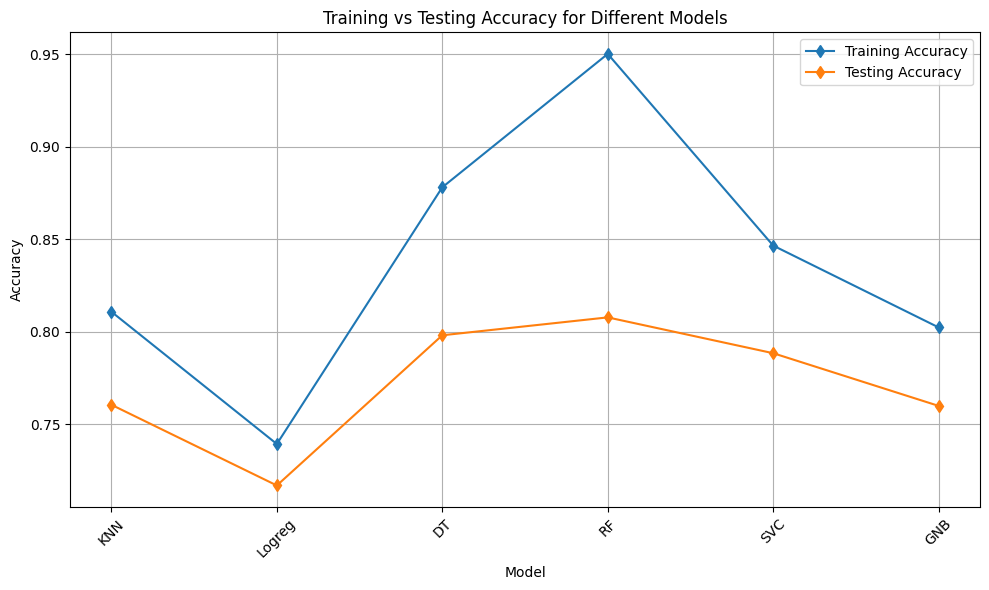

In [29]:
model_names = ['KNN', 'Logreg', 'DT', 'RF', 'SVC', 'GNB']
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_accuracies, marker='d', label='Training Accuracy')
plt.plot(model_names, test_accuracies, marker='d', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### All Algorithms Implementation

In [30]:
"""from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np

decision_tree = DecisionTreeClassifier(random_state=116)
random_forest = RandomForestClassifier(random_state=116)
svm = SVC(random_state=116)
naive_bayes = GaussianNB()
logreg = LogisticRegression(multi_class='multinomial',random_state=116)
knn = KNeighborsClassifier()

param_grid_decision_tree = {
    'criterion': ['gini'],
    'splitter': ['best'],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': [None],
}

param_grid_random_forest = {
    'n_estimators': [50],
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

param_grid_svm = {
    'C': [215.44346900318823],
    'kernel': ['rbf'],
    'degree': [2],
    'gamma': ['scale'],
    'coef0': [0.0]
}

param_grid_naive_bayes = {
    'priors': [None],
    'var_smoothing': [1e-9]
}

param_grid_logreg = {
    'penalty': ['l1'],
    'C': [215.44346900318823],
    'solver': ['saga'],
    'max_iter': [400]
}

param_grid_knn = {
    'n_neighbors': [11],
    'metric': ['manhattan'],
    'p': [1],
}

def get_models_and_params():
    return [
        ('Decision Tree', decision_tree, param_grid_decision_tree),
        ('Random Forest', random_forest, param_grid_random_forest),
        ('SVC', svm, param_grid_svm),
        ('Gaussian Naive Bayes', naive_bayes, param_grid_naive_bayes),
        ('Logistic Regression', logreg, param_grid_logreg),
        ('KNN', knn, param_grid_knn),
    ]

num_folds = {
    'Decision Tree': 10,
    'Random Forest': 25,
    'SVC': 10,
    'Gaussian Naive Bayes': 25,
    'Logistic Regression': 25,
    'KNN': 15,
}

accuracy_scores = []
train_accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
models_names = []


for name, model, param_grid in get_models_and_params():
    print(f"Training and evaluating {name}...")
    
    num_fold = num_folds[name]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=116)
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=kf,
        n_iter=168,
        scoring='accuracy',
        n_jobs=-1,
        random_state=116
    )
    random_search.fit(X_train_scaled, y_train)
    
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)
    
    f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
    print(f'{name}:\t{f1}% F1')
    
    recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
    print(f'{name}:\t{recall}% Recall')
    
    precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)
    print(f'{name}:\t{precision}% precision')
    
    accuracy=np.round(accuracy_score(y_test, y_pred)*100, 2)
    print(f'{name}:\t{accuracy}% Accuracy')
    
    accuracy1=np.round(best_model.score(X_test_scaled, y_test)*100, 2)
    print(f'{name}:\t{accuracy1}% Accuracy')
    
    
    train_accuracy=np.round(best_model.score(X_train_scaled, y_train)*100, 2)
    print(f'{name}:\t{train_accuracy}% Accuracy\n')
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    train_accuracy_scores.append(train_accuracy)
    models_names.append(name)"""

'from sklearn.model_selection import RandomizedSearchCV, KFold\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score\nimport numpy as np\n\ndecision_tree = DecisionTreeClassifier(random_state=116)\nrandom_forest = RandomForestClassifier(random_state=116)\nsvm = SVC(random_state=116)\nnaive_bayes = GaussianNB()\nlogreg = LogisticRegression(multi_class=\'multinomial\',random_state=116)\nknn = KNeighborsClassifier()\n\nparam_grid_decision_tree = {\n    \'criterion\': [\'gini\'],\n    \'splitter\': [\'best\'],\n    \'max_depth\': [10],\n    \'min_samples_split\': [5],\n    \'min_samples_leaf\': [1],\n    \'max_features\': [None],\n}\n\nparam_grid_random_forest = {\n    

In [31]:
#accuracy_scores

In [32]:
"""import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for model_name in models_names:
    model_scores = [accuracy_scores[models_names.index(model_name)],
                    f1_scores[models_names.index(model_name)],
                    precision_scores[models_names.index(model_name)],
                    recall_scores[models_names.index(model_name)]]

    score_labels = ['Accuracy', 'F1-score','Precision' ,'Recall']

    plt.plot(score_labels, model_scores, marker='o', label=model_name)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('Scores for Different Models')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()"""

"import matplotlib.pyplot as plt\nimport numpy as np\n\nplt.figure(figsize=(10, 6))\n\nfor model_name in models_names:\n    model_scores = [accuracy_scores[models_names.index(model_name)],\n                    f1_scores[models_names.index(model_name)],\n                    precision_scores[models_names.index(model_name)],\n                    recall_scores[models_names.index(model_name)]]\n\n    score_labels = ['Accuracy', 'F1-score','Precision' ,'Recall']\n\n    plt.plot(score_labels, model_scores, marker='o', label=model_name)\n\nplt.xlabel('Evaluation Metrics')\nplt.ylabel('Scores')\nplt.title('Scores for Different Models')\nplt.grid(True)\nplt.legend()\nplt.xticks(rotation=45)\nplt.show()"

In [33]:
"""model_names = ['Decision Tree', 'Random Forest', 'SVM', 'Gaussian Naive Bayes', 'Logistic Regression', 'K-Neighbors']
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_accuracy_scores, marker='d', label='Training Accuracy')
plt.plot(model_names, accuracy_scores, marker='d', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()"""

"model_names = ['Decision Tree', 'Random Forest', 'SVM', 'Gaussian Naive Bayes', 'Logistic Regression', 'K-Neighbors']\nplt.figure(figsize=(10, 6))\nplt.plot(model_names, train_accuracy_scores, marker='d', label='Training Accuracy')\nplt.plot(model_names, accuracy_scores, marker='d', label='Testing Accuracy')\nplt.title('Training vs Testing Accuracy for Different Models')\nplt.xlabel('Model')\nplt.ylabel('Accuracy')\nplt.xticks(rotation=45)\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()"

### Pipeline

In [34]:
"""from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

class ClassifierTransformer(TransformerMixin):
    def __init__(self, classifier=None):
        if classifier is None:
            raise ValueError("A classifier object is required")
        self.classifier = classifier

    def fit(self, X, y):
        self.classifier.fit(X, y)
        return self

    def transform(self, X):
        return self.classifier.predict(X).reshape(-1, 1)
    
    def predict(self, X):
        return self.classifier.predict(X)
    
    def score(self, X, y):
        return self.classifier.score(X, y)
    
    def get_params(self, deep=True):
        return {}

decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm = SVC()
naive_bayes = GaussianNB()
logreg = LogisticRegression()
knn = KNeighborsClassifier()

classifiers = [
    ('Decision Tree', ClassifierTransformer(classifier=decision_tree)),
    ('Random Forest', ClassifierTransformer(classifier=random_forest)),
    ('SVM', ClassifierTransformer(classifier=svm)),
    ('Naive Bayes', ClassifierTransformer(classifier=naive_bayes)),
    ('Logistic Regression', ClassifierTransformer(classifier=logreg)),
    ('KNN', ClassifierTransformer(classifier=knn))
]

pipelines = []
for name, classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    pipelines.append((name, pipeline))

pipeline_all_algorithms = Pipeline([
    ('union', FeatureUnion(transformer_list=pipelines))
])

pipeline_all_algorithms.fit(X_train_scaled, y_train)
"""

'from sklearn.base import TransformerMixin\nfrom sklearn.pipeline import Pipeline, FeatureUnion\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.linear_model import LogisticRegression\n\nclass ClassifierTransformer(TransformerMixin):\n    def __init__(self, classifier=None):\n        if classifier is None:\n            raise ValueError("A classifier object is required")\n        self.classifier = classifier\n\n    def fit(self, X, y):\n        self.classifier.fit(X, y)\n        return self\n\n    def transform(self, X):\n        return self.classifier.predict(X).reshape(-1, 1)\n    \n    def predict(self, X):\n        return self.classifier.predict(X)\n    \n    def score(self, X, y):\n        return self.classifier.score(X, y)\n    \n    def get_params(self, deep=True):\n        return {}\n\ndeci

In [35]:
"""import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

num_splits = {
    'Decision Tree': 10,
    'Random Forest': 25,
    'SVM': 10,
    'Naive Bayes': 25,
    'Logistic Regression': 25,
    'KNN': 15
}

train_accuracies = {}
test_accuracies = {}

for name, classifier in classifiers:
    print(f"Performing RandomizedSearchCV for {name} with {num_splits[name]} splits:")
    
    randomized_search = RandomizedSearchCV(
        estimator=pipeline_all_algorithms,
        param_distributions={
    'DecisionTreeClassifier': {
        'splitter': ['best'],
        'min_samples_split': [5],
        'min_samples_leaf': [1],
        'max_features': [None],
        'max_depth': [10],
        'criterion': ['gini'],
    },
    'RandomForestClassifier': {
        'n_estimators': [50],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': ['sqrt'],
        'max_depth': [None],
        'criterion': ['gini'],
        'bootstrap': [True],
    },
    'SVC': {
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'degree': [2],
        'coef0': [0.0],
        'C': [215.44346900318823],
    },
    'GaussianNB': {
        'priors' : [None],
        'var_smoothing' : [1e-9],
    },
    'LogisticRegression': {
        'solver': ['saga'],
        'penalty': ['l1'],
        'max_iter': [400],
        'C': [215.44346900318823],
    },
    'KNeighborsClassifier': {
        'p': [1],
        'n_neighbors': [11],
        'metric': ['manhattan'],
    }    
},
        n_iter=10,
        scoring='accuracy',
        cv=num_splits[name],
        verbose=2,
        n_jobs=-1
    )
    
    randomized_search.fit(X_train_scaled, y_train)
    
    train_accuracies[name] = accuracy_score(y_train, randomized_search.predict(X_train_scaled))
    test_accuracies[name] = accuracy_score(y_test, randomized_search.predict(X_test_scaled))
    
    print("Best parameters:", randomized_search.best_params_)
    print("Training accuracy:", train_accuracies[name])
    print("Testing accuracy:", test_accuracies[name])
    print()

plt.figure(figsize=(10, 6))
plt.bar(train_accuracies.keys(), train_accuracies.values(), color='blue', alpha=0.5, label='Training Accuracy')
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='red', alpha=0.5, label='Testing Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracies')
plt.legend()
plt.xticks(rotation=45)
plt.show()
"""

'import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import RandomizedSearchCV, train_test_split\nfrom sklearn.metrics import accuracy_score\n\nnum_splits = {\n    \'Decision Tree\': 10,\n    \'Random Forest\': 25,\n    \'SVM\': 10,\n    \'Naive Bayes\': 25,\n    \'Logistic Regression\': 25,\n    \'KNN\': 15\n}\n\ntrain_accuracies = {}\ntest_accuracies = {}\n\nfor name, classifier in classifiers:\n    print(f"Performing RandomizedSearchCV for {name} with {num_splits[name]} splits:")\n    \n    randomized_search = RandomizedSearchCV(\n        estimator=pipeline_all_algorithms,\n        param_distributions={\n    \'DecisionTreeClassifier\': {\n        \'splitter\': [\'best\'],\n        \'min_samples_split\': [5],\n        \'min_samples_leaf\': [1],\n        \'max_features\': [None],\n        \'max_depth\': [10],\n        \'criterion\': [\'gini\'],\n    },\n    \'RandomForestClassifier\': {\n        \'n_estimators\': [50],\n        \'min_samples_split\': [2],

In [36]:
"""from sklearn.metrics import classification_report

y_preds = []
accuracies = []
for name, transformer in pipeline_all_algorithms.named_steps['union'].transformer_list:
    y_pred = transformer.predict(X_test_scaled)
    y_preds.append(y_pred)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

y_pred_combined = np.hstack(y_preds)

average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)"""

'from sklearn.metrics import classification_report\n\ny_preds = []\naccuracies = []\nfor name, transformer in pipeline_all_algorithms.named_steps[\'union\'].transformer_list:\n    y_pred = transformer.predict(X_test_scaled)\n    y_preds.append(y_pred)\n    accuracy = np.mean(y_pred == y_test)\n    accuracies.append(accuracy)\n\ny_pred_combined = np.hstack(y_preds)\n\naverage_accuracy = np.mean(accuracies)\nprint("Average Accuracy:", average_accuracy)'

In [37]:
#accuracies

In [38]:
"""[0.7581818181818182,
 0.7836363636363637,
 0.7,
 0.76,
 0.6181818181818182,
 0.7254545454545455]"""

'[0.7581818181818182,\n 0.7836363636363637,\n 0.7,\n 0.76,\n 0.6181818181818182,\n 0.7254545454545455]'